In [1]:
import numpy as np

from scipy.io import loadmat
from scipy.io import savemat

from datetime import date
from datetime import timedelta

import matplotlib.pyplot as plt
%matplotlib inline

import os

from scipy.stats import mode
from scipy.interpolate import interp1d

### Herc Dome

In [2]:
#input and output files for loading and saving
herc_gps_in_file = 'HD_precisionGPS_2018_Day3_mod.mat'
herc_file = 'x53_interp_v1.mat'

#load in precision gps file
gps = loadmat(herc_gps_in_file)

#load in scg data line
herc = loadmat(herc_file)

#rename the 'gps_decday' key to 'decday' for impdar interpolation 
#gps['decday'] = gps.pop('gps_decday')

### Need to give `herc_file` a new x and y coordinate (like in `herc_dome_decday.ipynb`)

In [3]:
herc.keys()

dict_keys(['__header__', '__version__', '__globals__', 'avg_dist', 'chan', 'decday', 'dist', 'dt', 'elev', 'flags', 'lat', 'long', 'pressure', 'sddev_dist', 'snum', 'tnum', 'trace_int', 'trace_num', 'travel_time', 'trig', 'trig_level', 'uice', 'x_coord', 'y_coord', 'data'])

In [4]:
for k, v in herc.items():
    #if len(v) > 1000:
        print(k, np.shape(v))

__header__ ()
__version__ ()
__globals__ (0,)
avg_dist (1, 1)
chan (1, 1)
decday (1553, 1)
dist (1, 1553)
dt (1, 1)
elev (1553, 1)
flags (1, 1)
lat (1553, 1)
long (1553, 1)
pressure (1553, 1)
sddev_dist (1, 1)
snum (1, 1)
tnum (1, 1)
trace_int (1553, 1)
trace_num (1, 1553)
travel_time (1, 8320)
trig (1, 1)
trig_level (1, 1294)
uice (1, 1)
x_coord (1553, 1)
y_coord (1553, 1)
data (8320, 1553)


In [5]:
herc['data'] = herc['data'][:, :1450]

herc['elev'] = herc['elev'][:1450]
herc['lat'] = herc['lat'][:1450]
herc['long'] = herc['long'][:1450]
herc['trace_int'] = herc['trace_int'][:1450]
herc['x_coord'] = herc['x_coord'][:1450]
herc['y_coord'] = herc['y_coord'][:1450]
herc['decday'] = herc['decday'][:1450]
herc['pressure'] = herc['pressure'][:1450]

herc['dist'] = herc['dist'][0][:1450]
herc['trace_num'] = herc['trace_num'][0][:1450]

#savemat('x53_migtk_v2.mat', herc)

In [6]:
for k, v in herc.items():
    if len(v):
        print(k, np.shape(v))

__header__ ()
__version__ ()
avg_dist (1, 1)
chan (1, 1)
decday (1450, 1)
dist (1450,)
dt (1, 1)
elev (1450, 1)
flags (1, 1)
lat (1450, 1)
long (1450, 1)
pressure (1450, 1)
sddev_dist (1, 1)
snum (1, 1)
tnum (1, 1)
trace_int (1450, 1)
trace_num (1450,)
travel_time (1, 8320)
trig (1, 1)
trig_level (1, 1294)
uice (1, 1)
x_coord (1450, 1)
y_coord (1450, 1)
data (8320, 1450)


In [7]:
#savemat('x53_interp_clipped.mat', herc)

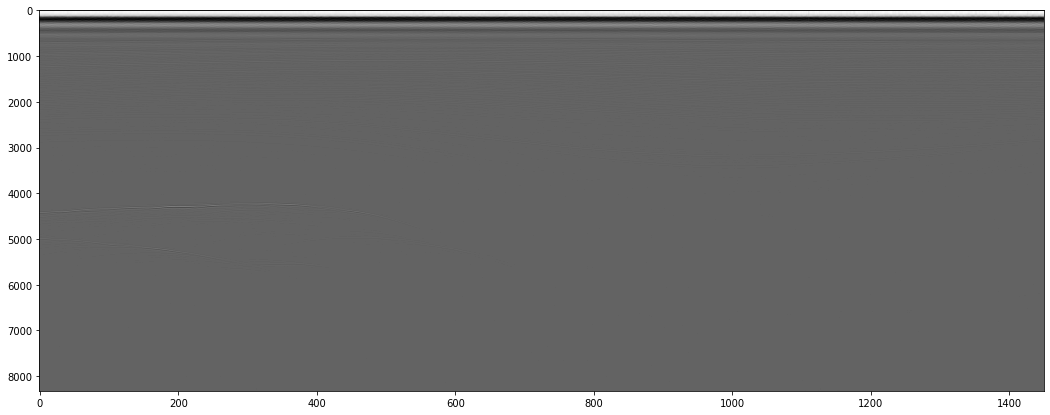

In [8]:
fig, ax = plt.subplots(figsize=(18, 7))

ax.imshow(herc['data'], cmap='gray', aspect='auto')

plt.show()

In [9]:
plt.scatter(herc['decday'], herc['x']/1000)
plt.scatter(gps['decday'], gps['x']/1000)

plt.show()

KeyError: 'x'

In [47]:
"""
We need to make sure that the two variables are close, otherwise we should stop the method.
Check that mwindow is a float
"""
def find_dt_offset(gps, radar, decday_var='decday', compare_var='lat', mwindow=1.):

    #make copies of time and x-coordinate arrays from radar
    t_radar = radar[decday_var][0].copy()
    y_radar = radar[compare_var][0].copy()

    #calculate rate of change for radar time
    dt_radar = mode(np.gradient(t_radar))[0][0]

    #make copies of time and x-coordinate arrays from precision gps
    t_gps = np.squeeze(gps[decday_var]).copy()
    y_gps = np.squeeze(gps[compare_var]).copy()

    #creating a function that will resample data points 
    interp = interp1d(t_gps,y_gps,fill_value='extrapolate')

    #creating new precision gps arrays from dt_radar
    t_gps_new = np.arange(t_gps[0],t_gps[-1],dt_radar)
    y_gps_new = interp(t_gps_new)

    #empty list to save cross-correlation values
    xcorr_listy = np.zeros(len(t_gps_new)-len(t_radar))

    #iterate trough the precision gps array for a time step of 1 
    #until we have gone through all of the data
    for i in range(len(t_gps_new)-len(t_radar)):
        minutes_to_days = 1./(24.*60.)
        minute_window = mwindow

        if np.abs(t_gps_new[i] - t_radar[0]) < minute_window*minutes_to_days:
            tempy = y_gps_new[i:i+len(y_radar)]
            #Covariance matrix: subset for gps-radar: [[gps-gps, gps-radar], [radar-gps, radar-radar]]
            xcorry = abs(np.corrcoef(y_radar, tempy)[0, 1])
            #append to xcorr to list
            xcorr_listy[i] = xcorry

    #calculate offset
    offset = t_radar[0] - t_gps_new[np.argmax(xcorr_listy)]
    
    #print the offset to the user
    print('The decday time offset is: {}'.format(offset))
    
    #returrn the offset value for further use
    return offset

In [94]:
"""
Make sure that the offset is a float
That add or subtract is a string
That saveas is a string
that limitx and limit y both are of type list, contain at least one number, which are floats
"""
def plot_offset(gps, radar, offset, decday_var='decday', compare_var='lat', limitx=None, limity=None):
    #set figure and axis for subplots
    fig, ax = plt.subplots(1, 2, figsize=(12, 8))

    #plot full scale of gps and radar data for the compare_var variable
    ax[0].scatter(np.squeeze(gps[decday_var]), np.squeeze(gps[compare_var]), s=1)
    ax[0].scatter(np.squeeze(radar[decday_var]), np.squeeze(radar[compare_var]), label='original', s=1)

    #plot full second plot of gps and radar data to zoom in
    ax[1].scatter(np.squeeze(gps[decday_var]), np.squeeze(gps[compare_var]), s=1)
    ax[1].scatter(np.squeeze(radar[decday_var]), np.squeeze(radar[compare_var]), label='original', s=1)
    
    #take absolute value of the time offset, so that we can always subtract it
    offset = np.abs(offset)
    
    #subtract the offset
    ax[0].scatter(np.squeeze(radar[decday_var]-offset), np.squeeze(radar[compare_var]), label='shifted', s=1)
    ax[1].scatter(np.squeeze(radar[decday_var]-offset), np.squeeze(radar[compare_var]), label='shifted', s=1)
        
    #set axis limits if the user inputs them
    if limitx != None:
        ax[1].set_xlim(limitx[0], limitx[1])
        
    if limity != None:
        ax[1].set_ylim(limity[0], limity[1])

    #add axis labels; the xlabel is shared between the subplots
    ax[0].set_ylabel(compare_var, fontsize=18)
    fig.text(0.5, 0.04, decday_var, ha='center', fontsize=18)
    
    #set title
    plt.suptitle('Time offset for the precision gps and radar using the variable: {}'.format(compare_var), fontsize=16, y=0.95)
    
    #set legends for both subplots
    ax[0].legend()
    ax[1].legend()
        
    plt.show()

The decday time offset is: 0.0006686222041025758


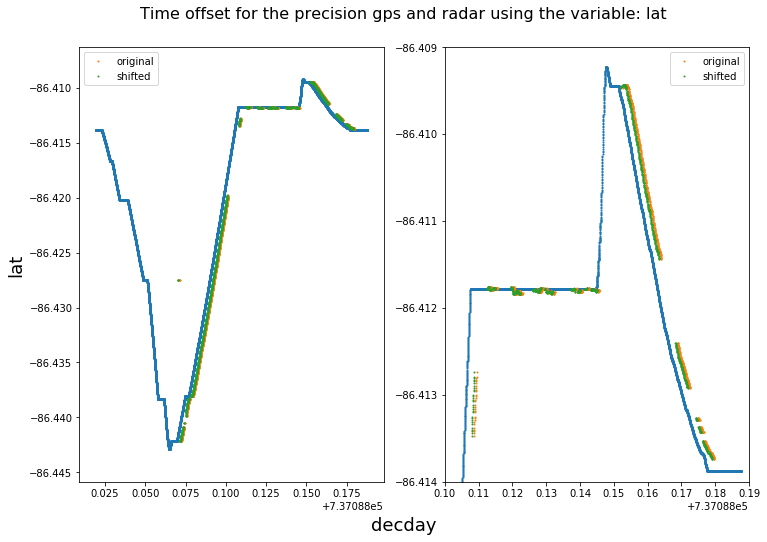

In [95]:
offset = find_dt_offset(gps, herc, compare_var='lat', mwindow=1.)

plot_offset(gps, herc, offset, 'decday', 'lat', limitx=[0.1+7.37088e5, 0.19+7.37088e5], limity=[-86.414, -86.409])

We are getting pretty good results, but we need to get closer to the original data.

The decday time offset is: -0.0006802662974223495


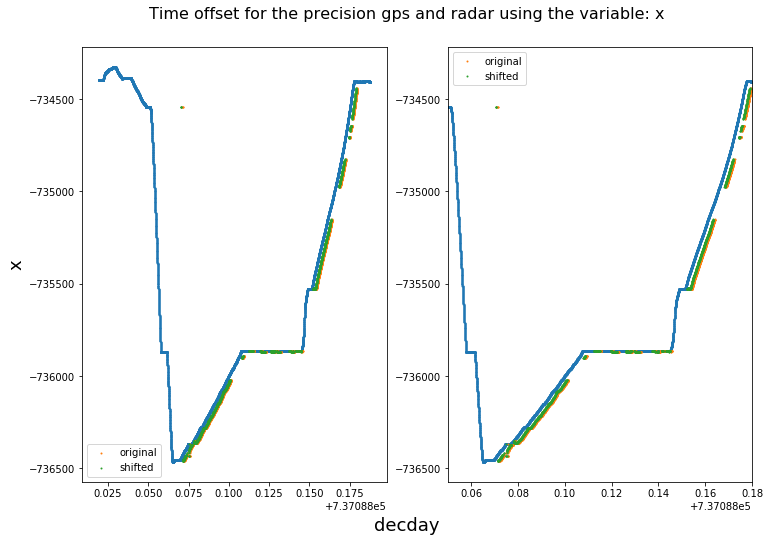

In [96]:
offset = find_dt_offset(gps, herc, compare_var='x', mwindow=1.)

plot_offset(gps, herc, offset, compare_var='x', limitx=[0.050+7.37088e5, 0.18+7.37088e5])